# VinBigData Chest X-ray Abnormalities Detectionm

### Automatically localize and classify thoracic abnormalities from chest radiographsm

Page:
https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection

# Import Packages

In [256]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import pathlib
from pprint import pprint

#img
import cv2

#pytorch
import torch
from torch import nn
from torch import functional as F
from torch import optim
from torch.utils.data import Dataset,DataLoader,random_split
from torchvision import transforms
from torch.nn import Module
from torchvision import models
from PIL import Image
#dicom
import pydicom

In [257]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader
from albumentations.pytorch.transforms import ToTensorV2
from tqdm.notebook import tqdm
import albumentations as A


#set Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [258]:
#-----path-----
#train csv
train_csv_path=pathlib.\
        Path("../input/vinbigdata-chest-xray-abnormalities-detection/train.csv")
sample_sub_path=pathlib.\
        Path("../input/vinbigdata-chest-xray-abnormalities-detection/sample_submission.csv")
#dicom data
train_data_path=pathlib.\
        Path("../input/vinbigdata-chest-xray-abnormalities-detection/train")
test_data_path=pathlib.\
        Path("../input/vinbigdata-chest-xray-abnormalities-detection/test")

In [259]:
#trainデータのindexリストを取得する。
image_ids=[x for x in train_data_path.iterdir() if x.is_file()]
len(image_ids)

15000

# DataFrame : Train Data

In [260]:
#train csv
df=pd.read_csv(train_csv_path)
df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN


In [261]:
#image id部分のみを分割
sample_=pathlib.\
    Path('../input/vinbigdata-chest-xray-abnormalities-detection/train/000434271f63a053c4128a0ba6352c7f.dicom')
#拡張子のみを取得する
print("拡張子；",image_ids[0].suffix)
#拡張子なしのidのみを取得
print("拡張子なしのファイル名取得:",image_ids[0].stem)

拡張子； .dicom
拡張子なしのファイル名取得: 4d390e07733ba06e5ff07412f09c0a92


In [262]:
#bounding boxを取得することは可能。
df[df["image_id"]==sample_.stem]

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
689,000434271f63a053c4128a0ba6352c7f,No finding,14,R6,NaN,NaN,NaN,NaN
56742,000434271f63a053c4128a0ba6352c7f,No finding,14,R2,NaN,NaN,NaN,NaN
65515,000434271f63a053c4128a0ba6352c7f,No finding,14,R3,NaN,NaN,NaN,NaN


# dataframeの欠損値を修正


## 1. class Name: No finding はデータなしに該当

>0 - Aortic enlargement
1 - Atelectasis
2 - Calcification
3 - Cardiomegaly
4 - Consolidation
5 - ILD
6 - Infiltration
7 - Lung Opacity
8 - Nodule/Mass
9 - Other lesion
10 - Pleural effusion
11 - Pleural thickening
12 - Pneumothorax
13 - Pulmonary fibrosis

### No_findingに該当するには14に指定


#### columns;x_min	y_min	x_max	y_maxはNaNになっているため欠損値補完が必要




In [263]:
df.isnull().sum()
#上記意外に欠損値はなさそう。

image_id          0
class_name        0
class_id          0
rad_id            0
x_min         31818
y_min         31818
x_max         31818
y_max         31818
dtype: int64

In [264]:
#bounding boxがない場合Nanとなっているため、穴埋め 
df.fillna(0,inplace=True)

In [265]:
#classid
"""
>0 - Aortic enlargement
1 - Atelectasis
2 - Calcification
3 - Cardiomegaly
4 - Consolidation
5 - ILD
6 - Infiltration
7 - Lung Opacity
8 - Nodule/Mass
9 - Other lesion
10 - Pleural effusion
11 - Pleural thickening
12 - Pneumothorax
13 - Pulmonary fibrosis
"""

df["class_id"].unique()

array([14,  3,  0, 11,  5,  8, 13,  7,  1,  9,  6, 10,  2,  4, 12])

In [266]:
# dicomデータの画像表示例
sample_ids=image_ids[10]
print(sample_ids.stem)
print(sample_ids.suffix)

98617a2bbd11c4afa7be664889cdd6de
.dicom


# DataSet and DataLoader

>1. multi boudingboxの出力に対応するために train_dataにあるimage_idをまず取得して、そのIDに該当するdataFrameデータを取得する。

>2.targetがマルチ出力になるため、dict形式で出力する

reference
https://www.kaggle.com/pestipeti/vinbigdata-fasterrcnn-pytorch-train

In [267]:
#Set Image Augumentation
from torchvision import transforms
import albumentations

transform=transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ]) 


In [268]:
class My_Dataset(Dataset):
    def __init__(self,df,):
        
        #dataframeを格納する
        self.df = df
        self.image_ids=df["image_id"].unique()
        self.image_dir=pathlib.\
                    Path("../input/vinbigdata-chest-xray-abnormalities-detection/train")
        #columnsを設定する
        self.box_col=["y_min","y_min","x_max","y_max"]
        #transform
        self.transform=transform
        
        
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self,index,transform=False):
        
        #train_data(dicom)よりrandomでdicomデータを取得
        image_id=self.image_ids[index]
        #print(image_id)
        
        #[dicom_data]
        dicom=pydicom.dcmread(str(self.image_dir/image_id)+".dicom")
        #[image array]
        image=dicom.pixel_array
        
        
        #add RGB channels
        #image=np.stack([image, image, image])
        
        #np.float32 and torch.Tensor
        image=torch.from_numpy(image.astype(np.float32))
        
        #transformer Gray->RGB
        #image=transforms.Lambda(lambda x:x.repeat(3,1,1))(image)
        
        
        """
        #[よくわからんここ調べる必要あり]
        if "PhotometricInterpretation" in dicom:
            if dicom.PhotometricInterpretation == "MONOCHROME1":
                image = np.amax(image) - image
        
        intercept = dicom.RescaleIntercept if "RescaleIntercept" in dicom else 0.0
        slope = dicom.RescaleSlope if "RescaleSlope" in dicom else 1.0
        
        if slope != 1:
            image = slope * image.astype(np.float64)
            image = image.astype(np.int16)
            
        image += np.int16(intercept)        
        #add RGBch
        image = np.stack([image, image, image])
        image = image.astype('float32')
        image = image - image.min()
        image = image / image.max()
        image = image * 255.0
        image = image.transpose(1,2,0)
        """
                
        
        #複数取得が発生するため、
        records = self.df[(self.df['image_id'] == image_id)]
        records = records.reset_index(drop=True)
        #print("records:",records)
        
        if records.loc[0, "class_id"] == 0:
            records = records.loc[[0], :]
        
        #records = self.df.loc[self.df.image_id == img_path.split('.')[0],:].reset_index(drop = True)
        
        #bounding box
        boxes = records[self.box_col].values
        #print(boxes)
        
        #----area-----

        area = (boxes[:,2] - boxes[:,0]) * (boxes[:,3] - boxes[:,1])
        #print(area)
        
        #----labels-----
        """
        0 - Aortic enlargement,1 - Atelectasis,2 - Calcification,3 - Cardiomegaly,4 - Consolidation,
        5 - ILD,6 - Infiltration,7 - Lung Opacity,8 - Nodule/Mass,9 - Other lesion,10 - Pleural effusion,
        11 - Pleural thickening,12 - Pneumothorax,13 - Pulmonary fibrosis
        14に該当するのはNoneっぽい
        
        """
        
        labels = torch.tensor(records["class_id"].values, dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        

        #[target]:dict
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        #target['iscrowd'] = iscrowd
        
        """
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.tensor(sample['bboxes'])
            
        """
        """
        #data output0の場合の設定を追加する。
        if target["boxes"].shape[0] == 0:
            # Albumentation cuts the target (class 14, 1x1px in the corner)
            target["boxes"] = torch.from_numpy(np.array([[0.0, 0.0, 1.0, 1.0]]))
            target["area"] = torch.tensor([1.0], dtype=torch.float32)
            target["labels"] = torch.tensor([0], dtype=torch.int64)
        """

        return image, target

In [291]:
train_dataset=My_Dataset(df=df)
train_dataloader=DataLoader(train_dataset,batch_size=1,shuffle=True)

In [292]:
# Output Sample
image,target=next(iter(train_dataloader))
print("image_tensor:",image.shape)
target

image_tensor: torch.Size([1, 3072, 3072])


{'boxes': tensor([[[ 767.,  767., 1259., 2137.],
          [ 958.,  958., 2457., 2159.],
          [ 767.,  767., 1259., 2137.],
          [ 591.,  591., 1298., 1049.],
          [ 686.,  686., 1312., 2032.],
          [ 981.,  981., 2461., 2231.],
          [ 686.,  686., 1312., 2032.],
          [ 686.,  686., 1312., 2032.],
          [ 736.,  736., 2291., 1225.],
          [ 796.,  796., 1321., 2125.],
          [ 981.,  981., 2461., 2231.],
          [ 958.,  958., 2457., 2159.],
          [1165., 1165., 2484., 2191.],
          [ 958.,  958., 2457., 2159.],
          [1165., 1165., 2484., 2191.],
          [ 756.,  756., 1818., 1080.],
          [ 529.,  529., 1134.,  677.],
          [ 958.,  958., 2457., 2159.],
          [ 796.,  796., 1321., 2125.],
          [ 813.,  813., 1858., 1113.],
          [ 796.,  796., 1888., 1188.],
          [ 796.,  796., 1321., 2125.],
          [ 981.,  981., 2461., 2231.],
          [ 686.,  686., 1312., 2032.]]], dtype=torch.float64),
 'label

# torch.tensor -> opencvに戻す場合の注意点

Tensorからndarrayに戻す場合には画像がわずかに暗くなってしまうよう。以下参考


reference
https://discuss.pytorch.org/t/plot-torch-tensor-using-opencv/20059/2

after converting your torch tensor back to opencv ndarray, if you do an imshow the image will appear slightly darker due to standard normalization.

"""

def inverse_normalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

input = inverse_normalize(tensor=input, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
"""

# plot tensor image

In [293]:
#tensor-> ndarrayに変換
sample_image=image.detach().numpy()
print(sample_image[0].shape)
#bounding boxを取得
bbox=target["boxes"][0][0].detach().numpy().astype(int)
print(bbox)

(3072, 3072)
[ 767  767 1259 2137]


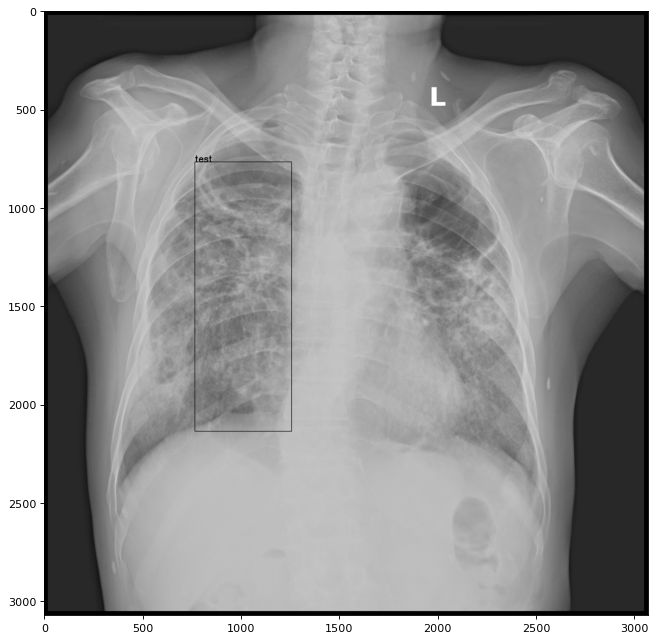

In [294]:
color = (0,0,255)
#bbox
cv2.rectangle(sample_image[0], 
              (bbox[0],bbox[1]), (bbox[2],bbox[3]), 
              (255,0,0), 2)
#label
cv2.putText(sample_image[0], "test",
            (bbox[0],bbox[1]),
            cv2.FONT_HERSHEY_SIMPLEX,
            1.5, color, 3)

#plot
plt.figure(num=None,figsize=(10, 10),dpi=80, facecolor='w', edgecolor='k')
plt.imshow(sample_image[0],cmap="gray")
plt.show()

In [295]:
boxes=target["boxes"][0].detach().numpy()
print(boxes)

[[ 767.  767. 1259. 2137.]
 [ 958.  958. 2457. 2159.]
 [ 767.  767. 1259. 2137.]
 [ 591.  591. 1298. 1049.]
 [ 686.  686. 1312. 2032.]
 [ 981.  981. 2461. 2231.]
 [ 686.  686. 1312. 2032.]
 [ 686.  686. 1312. 2032.]
 [ 736.  736. 2291. 1225.]
 [ 796.  796. 1321. 2125.]
 [ 981.  981. 2461. 2231.]
 [ 958.  958. 2457. 2159.]
 [1165. 1165. 2484. 2191.]
 [ 958.  958. 2457. 2159.]
 [1165. 1165. 2484. 2191.]
 [ 756.  756. 1818. 1080.]
 [ 529.  529. 1134.  677.]
 [ 958.  958. 2457. 2159.]
 [ 796.  796. 1321. 2125.]
 [ 813.  813. 1858. 1113.]
 [ 796.  796. 1888. 1188.]
 [ 796.  796. 1321. 2125.]
 [ 981.  981. 2461. 2231.]
 [ 686.  686. 1312. 2032.]]


#  Method tensor and target

出力は可能だが、boudingbox合ってる？

In [296]:
def draw_Tensor_BBox(tensor_image,target):
    
    #copy tensor(copy methodはtorch.tensorではclone)
    img=torch.clone(tensor_image[0])
    #tensor->ndarray
    img=img.detach().numpy()
    #print("image shape:\n",img.shape)
    
    #bounding box
    bboxes=target["boxes"][0].detach().numpy().astype(int)
    #print("bounding_box:\n",bboxes)
        
    #label name
    labels=target["labels"][0].detach().numpy()
        
    for bbox,label in zip(bboxes,labels):
        #bbox
        x = int(bbox[0])
        y = int(bbox[1])
        w = int(bbox[2])
        h = int(bbox[3])
        color = (0,0,255)
    
        #labelを付与(stringに変換する必要あり)
        cv2.putText(img,str(label), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1.5, color, 3)
        #cv2.rectangleのtuppleにはintを入力する(floatは不可)
        cv2.rectangle(img, (x, y), (w, h), (255,0,0), 2)
    
    plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
    plt.imshow(img,cmap="bone")
    plt.show()

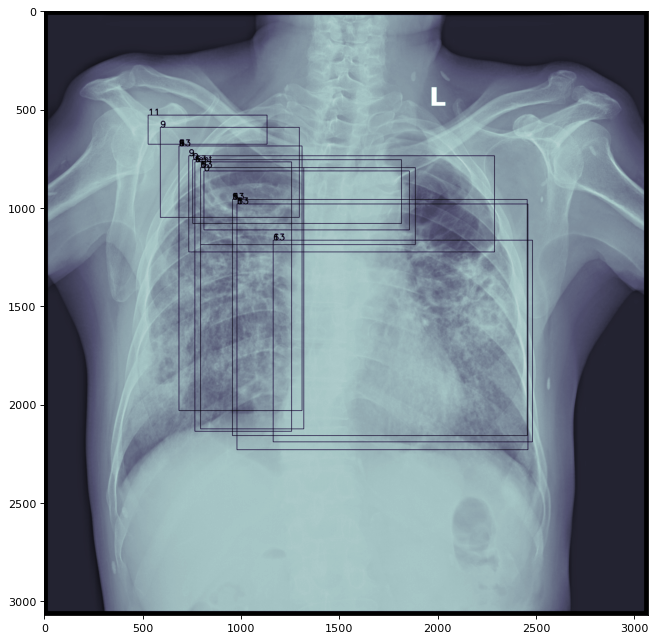

In [297]:
draw_Tensor_BBox(image,target)

# Resize Dicom and BoundingBox

dicomデータと同時にboundingboxを縮小する方法

reference:https://mikebird28.hatenablog.jp/entry/2020/06/26/211640

In [298]:
#上記を調整する。
sample_data=image[0].detach().numpy()
print(sample_data.shape)

#int変換に注意を
sample_bbox=target["boxes"][0][0].detach().numpy()
print(sample_bbox)

(3072, 3072)
[ 767.  767. 1259. 2137.]


In [299]:
def Resize(image, boxes, width, height):
    # 現在の高さと幅を取得しておく
    #c_height, c_width = image.shape[:2]
    
    #gray_scaleの場合
    c_height, c_width = image.shape
    
    img = cv2.resize(image, (width, height))
    print(img.shape)
    
    # 圧縮する比率(rate)を計算
    r_width = width / c_width
    r_height = width / c_height
    
    print("圧縮した比率：",r_width)
    print(r_height)
    # 比率を使ってBoundingBoxの座標を修正
    new_boxes = []
    print("resize前：",boxes)
    
    """
    for box in boxes:
        x = int(box.x * r_width)
        y = int(box.y * r_height)
        w = int(box.w * r_width)
        h = int(box.h * r_height)
        new_box = Box(x, y, w, h)
        new_boxes.append(new_box)
    """
    x=int(boxes[0]*r_width)
    y=int(boxes[1]*r_height)
    w=int(boxes[2]*r_width)
    h =int(boxes[3] * r_height)
    
    new_boxes=[x,y,w,h]
    print("resized bboxes:",new_boxes)
    
    return img, new_boxes


(500, 500)
圧縮した比率： 0.16276041666666666
0.16276041666666666
resize前： [ 767.  767. 1259. 2137.]
resized bboxes: [124, 124, 204, 347]
resized shape: (500, 500)


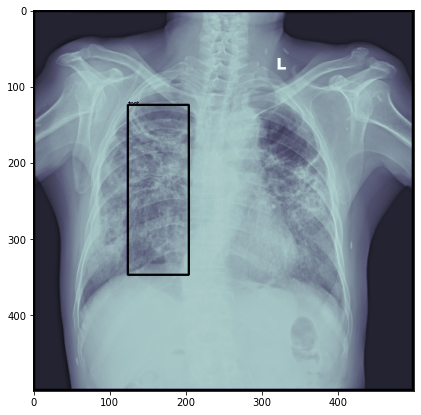

In [300]:
resized_image,resized_boxes = Resize(sample_data, sample_bbox, 500, 500)
#imshow(image, boxes, (255, 0, 0), 0.5)
print("resized shape:",resized_image.shape)

#append bbox
cv2.rectangle(resized_image, 
              (resized_boxes[0],resized_boxes[1]), (resized_boxes[2],resized_boxes[3]), 
              (255,0,0), 2)
#plot
plt.figure(figsize=(7,7))
plt.imshow(resized_image,cmap="bone")
plt.show()


# resizeで学習させた場合

比率を取得して元のサイズのbounding boxに戻せるように調整すると、
resizeの時点でintに変換しているためにinverse変換すると差異が大きい。

### 修正する必要大

In [309]:
#inverse_bbox
print(resized_boxes)
print(type(resized_boxes))

[124, 124, 204, 347]
<class 'list'>


In [310]:
#圧縮した比率： 0.2170138888888889とすると、
w_resize_ratio=0.2170138888888889
h_resize_ratio=0.1736111111111111
print(resized_boxes)

[124, 124, 204, 347]


In [311]:
inverse_boxes=[
               resized_boxes[0]/w_resize_ratio,
               resized_boxes[1]/h_resize_ratio,
               resized_boxes[2]/w_resize_ratio,
               resized_boxes[3]/h_resize_ratio
              ]
print(inverse_boxes)

#bboxをint変換してあるため、数値の差異が大きい。

[571.3919999999999, 714.24, 940.0319999999999, 1998.72]


In [312]:
target["boxes"]

tensor([[[ 767.,  767., 1259., 2137.],
         [ 958.,  958., 2457., 2159.],
         [ 767.,  767., 1259., 2137.],
         [ 591.,  591., 1298., 1049.],
         [ 686.,  686., 1312., 2032.],
         [ 981.,  981., 2461., 2231.],
         [ 686.,  686., 1312., 2032.],
         [ 686.,  686., 1312., 2032.],
         [ 736.,  736., 2291., 1225.],
         [ 796.,  796., 1321., 2125.],
         [ 981.,  981., 2461., 2231.],
         [ 958.,  958., 2457., 2159.],
         [1165., 1165., 2484., 2191.],
         [ 958.,  958., 2457., 2159.],
         [1165., 1165., 2484., 2191.],
         [ 756.,  756., 1818., 1080.],
         [ 529.,  529., 1134.,  677.],
         [ 958.,  958., 2457., 2159.],
         [ 796.,  796., 1321., 2125.],
         [ 813.,  813., 1858., 1113.],
         [ 796.,  796., 1888., 1188.],
         [ 796.,  796., 1321., 2125.],
         [ 981.,  981., 2461., 2231.],
         [ 686.,  686., 1312., 2032.]]], dtype=torch.float64)